In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd



path = os.listdir('/kaggle/input/reduced-mri-scans-data/dataset/train-data')
classes = {'zero':0, 'one':1}

import cv2
X = []
Y = []
for cls in classes:
    pth = '/kaggle/input/reduced-mri-scans-data/dataset/train-data/'+cls
    for j in os.listdir(pth):
        img = cv2.imread(pth+'/'+j, 0)
        img = cv2.resize(img, (200,200))
        X.append(img)
        Y.append(classes[cls])

X = np.array(X)
Y = np.array(Y)

X_updated = X.reshape(len(X), -1)
print(len(X))
print(len(Y))

np.unique(Y)

pd.Series(Y).value_counts()

X.shape, X_updated.shape

X_updated = X.reshape(len(X), -1)
X_updated.shape

xtrain, xtest, ytrain, ytest = train_test_split(X_updated, Y, random_state=10,
                                               test_size=.30)

xtrain.shape, xtest.shape

print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())
xtrain = xtrain/255
xtest = xtest/255
print(xtrain.max(), xtrain.min())
print(xtest.max(), xtest.min())


12952
12952
255 0
255 0
1.0 0.0
1.0 0.0


In [18]:
# Reshape the data back to 2D for CNN input
xtrain_cnn = xtrain.reshape(-1, 200, 200, 1)
xtest_cnn = xtest.reshape(-1, 200, 200, 1)

# Define the CNN model with Dropout layers
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)),
    MaxPooling2D((2, 2)),
#     Dropout(0.25),  # Dropout after first MaxPooling layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
#     Dropout(0.25),  # Dropout after second MaxPooling layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
#     Dropout(0.25),  # Dropout after third MaxPooling layer
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),  # Dropout before the final Dense layer
    Dense(1, activation='sigmoid')
])

In [19]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(xtrain_cnn, ytrain, epochs=10, validation_data=(xtest_cnn, ytest))


Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.6232 - loss: 0.6876 - val_accuracy: 0.6426 - val_loss: 0.6309
Epoch 2/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6693 - loss: 0.6078 - val_accuracy: 0.6909 - val_loss: 0.5683
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6951 - loss: 0.5703 - val_accuracy: 0.7285 - val_loss: 0.5262
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7461 - loss: 0.4985 - val_accuracy: 0.7849 - val_loss: 0.4777
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7868 - loss: 0.4436 - val_accuracy: 0.7797 - val_loss: 0.4733
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7850 - loss: 0.4347 - val_accuracy: 0.8003 - val_loss: 0.4394
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8163 - loss: 0.3866 - val_accuracy: 0.8242 - val_loss: 0.4293
Epoch 8/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8592 - loss: 0.3142 - val_ac

In [20]:
# Evaluate the model
loss, accuracy = model.evaluate(xtest_cnn, ytest)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8794 - loss: 0.4064
Test Accuracy: 87.93%


In [21]:
# Predict the labels on the test set
y_pred = (model.predict(xtest_cnn) > 0.5).astype("int32")

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [22]:
y_pred

array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [0]], dtype=int32)

              precision    recall  f1-score   support

        zero       0.88      0.81      0.84      1527
         one       0.88      0.93      0.90      2359

    accuracy                           0.88      3886
   macro avg       0.88      0.87      0.87      3886
weighted avg       0.88      0.88      0.88      3886



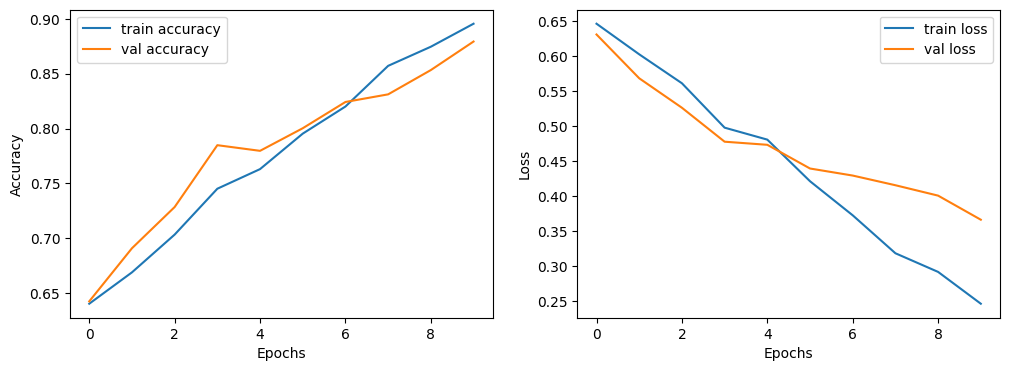

In [23]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(ytest, y_pred, target_names=classes.keys())
print(report)

# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()